# 多分类（多个logistic回归）
我们将扩展我们在练习2中写的logistic回归的实现，并将其应用于一对多的分类（不止两个类别）。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

## Dataset
首先，加载数据集。这里的数据为MATLAB的格式，所以要使用SciPy.io的loadmat函数。

In [2]:
def load_data(path):
    data = loadmat(path)
    X = data['X']
    y = data['y']
    return X, y

In [3]:
X,y = load_data('ex3data1.mat')
np.unique(y) # 查看标签类数

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

其中有5000个训练样本，每个样本是20*20像素的数字的灰度图像。每个像素代表一个浮点数，表示该位置的灰度强度。20×20的像素网格被展开成一个400维的向量。在我们的数据矩阵X中，每一个样本都变成了一行，这给了我们一个5000×400矩阵X，每一行都是一个手写数字图像的训练样本。


第一个任务是将我们的逻辑回归实现修改为完全向量化（即没有“for”循环）。这是因为向量化代码除了简洁外，还能够利用线性代数优化，并且通常比迭代代码快得多。

## Visualizing the data

In [4]:
def plot_an_image(X):
    """
    随机打印一个数字
    """
    pick_one=np.random.randint(0,X.shape[0])
    image=X[pick_one,:]
    fig,ax=plt.subplots(figsize=(1,1))
    ax.matshow(image.reshape(20,20),cmap='gray_r')
    plt.xticks([]) # 去除刻度，美观
    plt.yticks([])
    plt.show()
    print('this should be {}'.format(y[pick_one]))

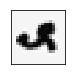

this should be [2]


In [5]:
plot_an_image(X)

In [6]:
def plot_100_image(X):
    """ 
    随机画100个数字
    """
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 随机选100个样本
    sample_image = X[sample_idx, :]
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True)
    for row in range(10):
        for column in range(10):
            ax_array[row,column].matshow(sample_image[10*row+column].reshape(20,20),cmap='gray_r')
    plt.xticks([]) # 去除刻度，美观
    plt.yticks([])
    plt.show()

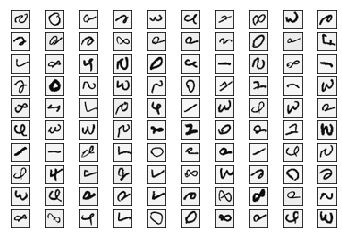

In [7]:
plot_100_image(X)

## Vectorizing Logistic Regression
我们将使用多个one-vs-all(一对多)logistic回归模型来构建一个多类分类器。由于有10个类，需要训练10个独立的分类器。为了提高训练效率，重要的是向量化。在本节中，我们将实现一个不使用任何for循环的向量化的logistic回归版本。

### Vectorizing the cost function

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [9]:
def regularized_cost(theta,X,y,l):
    """
    don't penalize theta_0
    args:
        X: feature matrix, (m, n+1) # 插入了x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
    """
    thetaReg=theta[1:]
    first=(-y*np.log(sigmoid(X.dot(theta.T))))+(y-1)*np.log(1-sigmoid(X.dot(theta.T)))
    reg=(thetaReg.T.dot(thetaReg))*l/(2*len(y))
    return np.mean(first)+reg

### Vectorizing the gradient

In [10]:
def regularized_gradient(theta, X, y, l):
    """
    don't penalize theta_0
    args:
        l: lambda constant
    return:
        a vector of gradient
    """
    thetaReg = theta[1:]
    first = (1/len(y))*X.T.dot(sigmoid(X.dot(theta.T))-y)
    # 这里人为插入一维0，使得对theta_0不惩罚，方便计算
    reg = np.concatenate([np.array([0]), (l/len(y))*thetaReg])
    return first+reg

## One-vs-all Classification
这部分我们将实现一对多分类通过训练多个正则化logistic回归分类器，每个对应数据集中K类中的一个。

对于这个任务，我们有10个可能的类，并且由于logistic回归只能一次在2个类之间进行分类，每个分类器在“类别 i”和“不是 i”之间决定。 我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回shape为(k, (n+1))数组，其中 n 是参数数量。


In [11]:
from scipy.optimize import minimize

def oneVsAll(X,y,l,K):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
        K: numbel of labels
    return: trained parameters
    """
    all_theta=np.zeros((K,X.shape[1]))
    for i in range(1,K+1):
        theta=np.zeros(X.shape[1])
        y_i=np.array([1 if label==i else 0 for label in y])
        ret = minimize(fun=regularized_cost,x0=theta,args=(X,y_i,l),method="TNC",jac=regularized_gradient,options={'disp':True})
        all_theta[i-1,:]=ret.x
    return all_theta

这里需要注意的几点：首先，我们为X添加了一列常数项 1 ，以计算截距项（常数项）。 其次，我们将y从类标签转换为每个分类器的二进制值（要么是类i，要么不是类i）。 最后，我们使用SciPy的较新优化API来最小化每个分类器的代价函数。 如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian（渐变）函数。 然后将优化程序找到的参数分配给参数数组。

实现向量化代码的一个更具挑战性的部分是正确地写入所有的矩阵，保证维度正确。

In [12]:
def predictOneVsAll(X,all_theta):
    # compute the class probability for each class on each training instance   
    h = sigmoid(X.dot(all_theta.T))  # 注意的这里的all_theta需要转置
    # create array of the index with the maximum probability
    # Returns the indices of the maximum values along an axis.
    h_argmax = np.argmax(h, axis=1)
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

这里的h共5000行，10列，每行代表一个样本，每列是预测对应数字的概率。我们取概率最大对应的index加1就是我们分类器最终预测出来的类别。返回的h_argmax是一个array，包含5000个样本对应的预测值。

In [13]:
raw_X,raw_y=load_data('ex3data1.mat')
X=np.insert(raw_X,0,1,axis=1)
y=raw_y.flatten() # 这里消除了一个维度，方便后面的计算 or .reshape(-1) （5000，）
all_theta=oneVsAll(X,y,1,10)
all_theta # 每一行是一个分类器的一组参数

array([[-2.38288762e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30490418e-03, -8.69230635e-10,  0.00000000e+00],
       [-3.18507043e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46039297e-03, -5.08537872e-04,  0.00000000e+00],
       [-4.79744465e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87410834e-05, -2.47567832e-07,  0.00000000e+00],
       ...,
       [-7.98700280e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.95816537e-05,  7.22988656e-06,  0.00000000e+00],
       [-4.57023836e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.34052738e-03,  1.00158635e-04,  0.00000000e+00],
       [-5.40404093e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16668325e-04,  7.88727338e-06,  0.00000000e+00]])

In [14]:
y_pred=predictOneVsAll(X,all_theta)
accuracy=np.mean(y_pred==y)
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.46%


# Neural Networks
上面使用了多类logistic回归，然而logistic回归不能形成更复杂的假设，因为它只是一个线性分类器。

接下来我们用神经网络来尝试下，神经网络可以实现非常复杂的非线性的模型。我们将利用已经训练好了的权重进行预测。

In [15]:
def load_weight(path):
    data=loadmat(path)
    return data['Theta1'],data['Theta2']

In [16]:
theta1,theta2=load_weight('ex3weights.mat')

因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）

In [17]:
X,y=load_data('ex3data1.mat')
y=y.flatten()
X=np.insert(X,0,1,axis=1)

In [18]:
a1=X
z2=a1.dot(theta1.T)

z2=np.insert(z2,0,1,axis=1)
a2=sigmoid(z2)

z3=a2.dot(theta2.T)
a3=sigmoid(z3)

In [19]:
y_pred=np.argmax(a3,axis=1)+1
accuracy=np.mean(y_pred==y)
